In [23]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Estimator, Sampler
from qiskit_aer.noise import NoiseModel

from squlearn import Executor
from squlearn.encoding_circuit import QiskitEncodingCircuit
from squlearn.observables import SinglePauli
from squlearn.qnn import QNNRegressor, SquaredLoss
from squlearn.optimizers import Adam, SLSQP, SGLBO

import matplotlib.pyplot as plt
import matplotlib as mpl

In [24]:
nqubits = 4

qc = QuantumCircuit(nqubits)
p = ParameterVector('p', 8)
x = ParameterVector('x', 1)

p2 = np.array([-0.13005136, -1.34331017, 2.44392299, 1.64405423, -0.36315523, 0.45344925,
 0.18577077, -0.13904446])

for i in range(nqubits):
 qc.h(i)
 qc.rx(1*np.arccos(x[0]), i)
 
qc.ry(p[0], 0)
qc.ry(p2[1], 1)
qc.ry(p2[2], 2)
qc.ry(p2[3], 3)

qc.cx(0, 1)
qc.cx(2, 3)
qc.cx(1, 2)
qc.cx(3, 0)

for i in range(nqubits):
 qc.h(i)
 qc.rx(1*np.arccos(x[0]), i)
 qc.ry(p2[i+nqubits], i)

pqc = QiskitEncodingCircuit(qc)
pqc.draw()

┌───┐┌────────────────┐  ┌──────────┐           ┌───┐┌───┐»
q_0: ┤ H ├┤ Rx(acos(x[0])) ├──┤ Ry(p[0]) ├───■───────┤ X ├┤ H ├»
     ├───┤├────────────────┤┌─┴──────────┴┐┌─┴─┐     └─┬─┘├───┤»
q_1: ┤ H ├┤ Rx(acos(x[0])) ├┤ Ry(-1.3433) ├┤ X ├──■────┼──┤ H ├»
     ├───┤├────────────────┤└┬────────────┤└───┘┌─┴─┐  │  ├───┤»
q_2: ┤ H ├┤ Rx(acos(x[0])) ├─┤ Ry(2.4439) ├──■──┤ X ├──┼──┤ H ├»
     ├───┤├────────────────┤ ├────────────┤┌─┴─┐└───┘  │  ├───┤»
q_3: ┤ H ├┤ Rx(acos(x[0])) ├─┤ Ry(1.6441) ├┤ X ├───────■──┤ H ├»
     └───┘└────────────────┘ └────────────┘└───┘          └───┘»
«     ┌────────────────┐┌──────────────┐
«q_0: ┤ Rx(acos(x[0])) ├┤ Ry(-0.36316) ├
«     ├────────────────┤├─────────────┬┘
«q_1: ┤ Rx(acos(x[0])) ├┤ Ry(0.45345) ├─
«     ├────────────────┤├─────────────┤ 
«q_2: ┤ Rx(acos(x[0])) ├┤ Ry(0.18577) ├─
«     ├────────────────┤├─────────────┴┐
«q_3: ┤ Rx(acos(x[0])) ├┤ Ry(-0.13904) ├
«     └────────────────┘└──────────────┘

In [25]:
op = SinglePauli(nqubits,qubit=0,parameterized=True)
print(op)

SparsePauliOp(['IIIZ'],
              coeffs=[ParameterExpression(1.0*p[0])])


In [26]:
op.num_parameters

1

In [27]:
# Randomly initialize parameters of the encoding circuit
np.random.seed(13) #13
param_ini =  np.random.rand(pqc.num_parameters)
# Initialize parameters of the observable as ones
param_op_ini = np.ones(op.num_parameters)
x0 = [[i * 0.2] for i in range(15)]
optimizer_options = {"bo_aqc_func": "EI", "bo_aqc_optimizer": "lbfgs", "bo_bounds": [(0.0, 5.0)], "log_file": "sglbo_noiseless.log",
                     "bo_n_calls": 30, "bo_x0_points": x0, "maxiter": 100}

qnn_simulator = QNNRegressor(
    pqc,
    op,
    Executor("statevector_simulator"),
    SquaredLoss(),
    SGLBO(optimizer_options),
    #SLSQP(),
    #Adam({"lr": 0.2,"log_file": "adam_noiseless.log"}),
    param_ini,
    param_op_ini=param_op_ini,
    opt_param_op=True, # Keine Observablen optimierung
    parameter_seed=124
)

In [28]:
print(param_ini)
print(param_op_ini)

[0.77770241]
[1.]


In [29]:
# Data that is inputted to the QNN
x_train = np.arange(-0.5, 0.6, 0.1)
# Data that is fitted by the QNN
y_train = np.sin(6.0*x_train)

In [30]:
def evaluate_loss(theta, qnn_regressor: QNNRegressor, X, y):
    param = theta[: qnn_regressor._qnn.num_parameters]
    param_op = theta[qnn_regressor._qnn.num_parameters :]

    loss_values = qnn_regressor._qnn.evaluate(qnn_regressor.loss.loss_args_tuple, X, param, param_op)

    loss_value = qnn_regressor.loss.value(
        loss_values,
        ground_truth=y,
        weights=np.ones(len(y)),
        iteration=0,
    )

    return loss_value




In [31]:
qnn_simulator.fit(x_train, y_train)



fit:   0%|          | 0/100 [00:00<?, ?it/s]BOP  fval:  5.003245588858223  x:  [0.0]
BOP  fval:  4.806639360562196  x:  [0.2]
BOP  fval:  4.663485963090701  x:  [0.4]
BOP  fval:  4.5865022206682635  x:  [0.6000000000000001]
BOP  fval:  4.580291167522197  x:  [0.8]
BOP  fval:  4.641060910737347  x:  [1.0]
BOP  fval:  4.757626622352162  x:  [1.2000000000000002]
BOP  fval:  4.9134545351751715  x:  [1.4000000000000001]
BOP  fval:  5.089348741996709  x:  [1.6]
BOP  fval:  5.266301852260869  x:  [1.8]
BOP  fval:  5.428038000114925  x:  [2.0]
BOP  fval:  5.562864358119455  x:  [2.2]
BOP  fval:  5.6645945869448395  x:  [2.4000000000000004]
BOP  fval:  5.732484776787976  x:  [2.6]
BOP  fval:  5.770296328509045  x:  [2.8000000000000003]
BOP  fval:  5.783524855001983  x:  [2.964223091125092]
BOP  fval:  5.7124294678998675  x:  [4.221328742905087]
BOP  fval:  5.704060696929801  x:  [4.289728088113785]
BOP  fval:  5.710694783435006  x:  [4.236258693920628]
BOP  fval:  5.785482022806071  x:  [3.11

C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.7067344894754917  x:  [0.0]
 Iteration:  4 :  gp_minimize:  fval:  2.5517228840681145  x:  [2.749785066485595] 
BOP  fval:  2.55091989818695  x:  [0.0]
BOP  fval:  2.5466102611913  x:  [0.2]
BOP  fval:  2.54285571092189  x:  [0.4]
BOP  fval:  2.539669326637472  x:  [0.6000000000000001]
BOP  fval:  2.5370642900070455  x:  [0.8]
BOP  fval:  2.535053884188544  x:  [1.0]
BOP  fval:  2.533651492895322  x:  [1.2000000000000002]
BOP  fval:  2.532870599450372  x:  [1.4000000000000001]
BOP  fval:  2.5327247858284228  x:  [1.6]
BOP  fval:  2.5332277316859226  x:  [1.8]
BOP  fval:  2.5343932133790235  x:  [2.0]
BOP  fval:  2.536235102969563  x:  [2.2]
BOP  fval:  2.538767367219152  x:  [2.4000000000000004]
BOP  fval:  2.5420040665714168  x:  [2.6]
BOP  fval:  2.5459593541224343  x:  [2.8000000000000003]
BOP  fval:  2.5497543833383536  x:  [2.964223091125092]
BOP  fval:  2.596024983366633  x:  [4.221328742905087]
BOP  fval:  2.5994575233630703  x:  [4.289728088113785]
BOP  fval:  2.5

C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.5327007907148262  x:  [0.0]
BOP  fval:  2.5191852056448094  x:  [0.028165430204863954]
BOP  fval:  2.51855774582815  x:  [0.025823284090979018]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.5327007907148262  x:  [0.0]
 Iteration:  6 :  gp_minimize:  fval:  2.5219522352816792  x:  [0.015629648414748225] 
BOP  fval:  2.5195297435831936  x:  [0.0]
BOP  fval:  2.594392472897336  x:  [0.2]
BOP  fval:  2.8710939776290254  x:  [0.4]
BOP  fval:  3.349697614851531  x:  [0.6000000000000001]
BOP  fval:  4.026931591644856  x:  [0.8]
BOP  fval:  4.896195507466608  x:  [1.0]
BOP  fval:  5.947625807136478  x:  [1.2000000000000002]
BOP  fval:  7.168219874798255  x:  [1.4000000000000001]
BOP  fval:  8.54201743648527  x:  [1.6]
BOP  fval:  10.050336884264272  x:  [1.8]
BOP  fval:  11.672063107706977  x:  [2.0]
BOP  fval:  13.383982437760608  x:  [2.2]
BOP  fval:  15.161159392504203  x:  [2.4000000000000004]
BOP  fval:  16.97734908143002  x:  [2.6]
BOP  fval:  18.80543839114665  x:  [2.8000000000000003]
BOP  fval:  20.296060907462923  x:  [2.964223091125092]
BOP  fval:  29.807723089959445  x:  [4.221328742905087]
BOP  fval:  30.163342978334043  x:  [4.289728088113785]
BOP  fva

C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.5195297435831936  x:  [0.0]
BOP  fval:  2.5195272162010682  x:  [2.005842783037171e-05]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.5195297435831936  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.5195297435831936  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.5195297435831936  x:  [0.0]
 Iteration:  7 :  gp_minimize:  fval:  2.5182794790734775  x:  [0.008175144548544679] 
BOP  fval:  2.518665360037115  x:  [0.0]
BOP  fval:  2.546470127431194  x:  [0.2]
BOP  fval:  2.654816687968538  x:  [0.4]
BOP  fval:  2.8448302191105594  x:  [0.6000000000000001]
BOP  fval:  3.1171083052029744  x:  [0.8]
BOP  fval:  3.47170874631616  x:  [1.0]
BOP  fval:  3.9081410737009366  x:  [1.2000000000000002]
BOP  fval:  4.425361889062546  x:  [1.4000000000000001]
BOP  fval:  5.021774118218601  x:  [1.6]
BOP  fval:  5.6952302420184395  x:  [1.8]
BOP  fval:  6.443039538851504  x:  [2.0]
BOP  fval:  7.2619793438695375  x:  [2.2]
BOP  fval:  8.148310300395208  x:  [2.4000000000000004]
BOP  fval:  9.097795549109206  x:  [2.6]
BOP  fval:  10.105723770720866  x:  [2.8000000000000003]
BOP  fval:  10.973431566140132  x:  [2.964223091125092]
BOP  fval:  18.4502789128306  x:  [4.221328742905087]
BOP  fval:  18.880701927106088  x:  [4.289728088113785]
BOP  fval:

C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.5135659982009027  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.5135659982009027  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.5135659982009027  x:  [0.0]
BOP  fval:  2.5135229237094174  x:  [0.0001208331231968454]
BOP  fval:  2.513464097616782  x:  [0.00028691110329820483]
 Iteration:  10 :  gp_minimize:  fval:  2.5122155628282403  x:  [0.007358551761154949] 
BOP  fval:  2.5113646192441905  x:  [0.0]
BOP  fval:  2.617468361935487  x:  [0.2]
BOP  fval:  3.0027267536976687  x:  [0.4]
BOP  fval:  3.664527129154703  x:  [0.6000000000000001]
BOP  fval:  4.594032123111142  x:  [0.8]
BOP  fval:  5.776300325922171  x:  [1.0]
BOP  fval:  7.190554270239036  x:  [1.2000000000000002]
BOP  fval:  8.81059139441598  x:  [1.4000000000000001]
BOP  fval:  10.605330087088028  x:  [1.6]
BOP  fval:  12.53947951854906  x:  [1.8]
BOP  fval:  14.57431879291799  x:  [2.0]
BOP  fval:  16.66856809164448  x:  [2.2]
BOP  fval:  18.779331998221572  x:  [2.4000000000000004]
BOP  fval:  20.863093162219403  x:  [2.6]
BOP  fval:  22.87673293403666  x:  [2.8000000000000003]
BOP  fval:  24.448350295159425  x:  [2.964223091125092]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.5113646192441905  x:  [0.0]
BOP  fval:  2.511361332164516  x:  [2.005842783037171e-05]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.5113646192441905  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.5113646192441905  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.5113646192441905  x:  [0.0]
 Iteration:  11 :  gp_minimize:  fval:  2.510111030698173  x:  [0.005636960198174984] 
BOP  fval:  2.510550149640545  x:  [0.0]
BOP  fval:  2.567323315107481  x:  [0.2]
BOP  fval:  2.777550490719055  x:  [0.4]
BOP  fval:  3.1419443687654707  x:  [0.6000000000000001]
BOP  fval:  3.6593275116475485  x:  [0.8]
BOP  fval:  4.326620757424849  x:  [1.0]
BOP  fval:  5.138856540491592  x:  [1.2000000000000002]
BOP  fval:  6.0892173065047555  x:  [1.4000000000000001]
BOP  fval:  7.169098864820061  x:  [1.6]
BOP  fval:  8.368198183217755  x:  [1.8]
BOP  fval:  9.674624793195603  x:  [2.0]
BOP  fval:  11.07503464418605  x:  [2.2]
BOP  fval:  12.55478492629302  x:  [2.4000000000000004]
BOP  fval:  14.098108078037729  x:  [2.6]
BOP  fval:  15.688302912495026  x:  [2.8000000000000003]
BOP  fval:  17.01684475748471  x:  [2.964223091125092]
BOP  fval:  26.778921893709022  x:  [4.221328742905087]
BOP  fval:  27.239567765986884  x:  [4.289728088113785]
BOP  fval

C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.510550149640545  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.510550149640545  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.510550149640545  x:  [0.0]
BOP  fval:  2.5104279188593397  x:  [0.0013032368255294637]
 Iteration:  12 :  gp_minimize:  fval:  2.5093922062140965  x:  [0.009671540845782603] 
BOP  fval:  2.509795919454103  x:  [0.0]
BOP  fval:  2.5251683892373675  x:  [0.2]
BOP  fval:  2.5876905930252994  x:  [0.4]
BOP  fval:  2.6981334478516543  x:  [0.6000000000000001]
BOP  fval:  2.857093187838333  x:  [0.8]
BOP  fval:  3.0649864632047357  x:  [1.0]
BOP  fval:  3.322046129027589  x:  [1.2000000000000002]
BOP  fval:  3.6283177511360165  x:  [1.4000000000000001]
BOP  fval:  3.98365685376022  x:  [1.6]
BOP  fval:  4.387726930644481  x:  [1.8]
BOP  fval:  4.839998238295371  x:  [2.0]
BOP  fval:  5.3397473868771765  x:  [2.2]
BOP  fval:  5.886057740998529  x:  [2.4000000000000004]
BOP  fval:  6.477820639276253  x:  [2.6]
BOP  fval:  7.1137374381191  x:  [2.8000000000000003]
BOP  fval:  7.667872407915149  x:  [2.964223091125092]
BOP  fval:  12.751137783136413  x:  [4.221328742905087]
BOP  fv

C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.5072124911641867  x:  [0.0]
BOP  fval:  2.50720930126534  x:  [2.005842783037171e-05]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.5072124911641867  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.5072124911641867  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.5072124911641867  x:  [0.0]
 Iteration:  15 :  gp_minimize:  fval:  2.5059594214234107  x:  [0.005168683713574359] 
BOP  fval:  2.506480806372119  x:  [0.0]
BOP  fval:  2.565629733205651  x:  [0.2]
BOP  fval:  2.783401233029575  x:  [0.4]
BOP  fval:  3.1603538999719043  x:  [0.6000000000000001]
BOP  fval:  3.6950469365799212  x:  [0.8]
BOP  fval:  4.384031773937341  x:  [1.0]
BOP  fval:  5.221870635016955  x:  [1.2000000000000002]
BOP  fval:  6.2011821621627945  x:  [1.4000000000000001]
BOP  fval:  7.312713858505365  x:  [1.6]
BOP  fval:  8.545440720409834  x:  [1.8]
BOP  fval:  9.886689068896898  x:  [2.0]
BOP  fval:  11.322284227544886  x:  [2.2]
BOP  fval:  12.836720347800766  x:  [2.4000000000000004]
BOP  fval:  14.413350354906427  x:  [2.6]
BOP  fval:  16.03459368357967  x:  [2.8000000000000003]
BOP  fval:  17.386334225799025  x:  [2.964223091125092]
BOP  fval:  27.21222771366432  x:  [4.221328742905087]
BOP  fval:  27.668942613606355  x:  [4.289728088113785]
BOP  fv

C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.506480806372119  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.506480806372119  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.506480806372119  x:  [0.0]
BOP  fval:  2.506410897031505  x:  [0.0007283019037185313]
 Iteration:  16 :  gp_minimize:  fval:  2.5053262347443326  x:  [0.008772431815958893] 
BOP  fval:  2.5057766262064765  x:  [0.0]
BOP  fval:  2.5246302000004226  x:  [0.2]
BOP  fval:  2.5990135203182336  x:  [0.4]
BOP  fval:  2.7297477795144145  x:  [0.6000000000000001]
BOP  fval:  2.917412570662595  x:  [0.8]
BOP  fval:  3.1623398332676262  x:  [1.0]
BOP  fval:  3.46460892152813  x:  [1.2000000000000002]
BOP  fval:  3.824042834460113  x:  [1.4000000000000001]
BOP  fval:  4.240205641879045  x:  [1.6]
BOP  fval:  4.712401134686592  x:  [1.8]
BOP  fval:  5.23967272214481  x:  [2.0]
BOP  fval:  5.82080459287027  x:  [2.2]
BOP  fval:  6.454324150173443  x:  [2.4000000000000004]
BOP  fval:  7.1385057261310525  x:  [2.6]
BOP  fval:  7.871375572444788  x:  [2.8000000000000003]
BOP  fval:  8.507998919335378  x:  [2.964223091125092]
BOP  fval:  14.258405606506098  x:  [4.221328742905087]
BOP  fva

C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.4956278030183148  x:  [0.0]
BOP  fval:  2.487716998461301  x:  [0.020565970349781068]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.4956278030183148  x:  [0.0]
 Iteration:  19 :  gp_minimize:  fval:  2.4918847041419223  x:  [0.008670710176889362] 
BOP  fval:  2.49038526224714  x:  [0.0]
BOP  fval:  2.684065997479418  x:  [0.2]
BOP  fval:  3.3670131429467873  x:  [0.4]
BOP  fval:  4.522401152179888  x:  [0.6000000000000001]
BOP  fval:  6.11565219935234  x:  [0.8]
BOP  fval:  8.095591154836786  x:  [1.0]
BOP  fval:  10.396269009938802  x:  [1.2000000000000002]
BOP  fval:  12.939389622849003  x:  [1.4000000000000001]
BOP  fval:  15.637249658037527  x:  [1.6]
BOP  fval:  18.39607992689178  x:  [1.8]
BOP  fval:  21.119658922989686  x:  [2.0]
BOP  fval:  23.713056934656052  x:  [2.2]
BOP  fval:  26.086362270610504  x:  [2.4000000000000004]
BOP  fval:  28.15824019345061  x:  [2.6]
BOP  fval:  29.85918022750431  x:  [2.8000000000000003]
BOP  fval:  30.939403035420163  x:  [2.964223091125092]
BOP  fval:  28.861137957170662  x:  [4.221328742905087]
BOP  fval:  28.29244934409405  x:  [4.289728088113785]
BOP  fva

C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.49038526224714  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.49038526224714  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.49038526224714  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.49038526224714  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.49038526224714  x:  [0.0]
 Iteration:  20 :  gp_minimize:  fval:  2.4891708681408353  x:  [0.004876932080315992] 
BOP  fval:  2.4892625591702675  x:  [0.0]
BOP  fval:  2.6007282159701886  x:  [0.2]
BOP  fval:  2.9978084666476366  x:  [0.4]
BOP  fval:  3.676933328910657  x:  [0.6000000000000001]
BOP  fval:  4.628389565502276  x:  [0.8]
BOP  fval:  5.83647126034313  x:  [1.0]
BOP  fval:  7.27976993740998  x:  [1.2000000000000002]
BOP  fval:  8.931599112895244  x:  [1.4000000000000001]
BOP  fval:  10.760544963553803  x:  [1.6]
BOP  fval:  12.731131743884122  x:  [1.8]
BOP  fval:  14.804587765658596  x:  [2.0]
BOP  fval:  16.939695234454184  x:  [2.2]
BOP  fval:  19.093705082103522  x:  [2.4000000000000004]
BOP  fval:  21.223296196435122  x:  [2.6]
BOP  fval:  23.285557176084662  x:  [2.8000000000000003]
BOP  fval:  24.899311285241545  x:  [2.964223091125092]
BOP  fval:  32.802354732075024  x:  [4.221328742905087]
BOP  fval:  32.93774443811585  x:  [4.289728088113785]
BOP  fv

C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.4892625591702675  x:  [0.0]
BOP  fval:  2.4892594526149088  x:  [2.005842783037171e-05]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.4892625591702675  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.4892625591702675  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.4892625591702675  x:  [0.0]
 Iteration:  21 :  gp_minimize:  fval:  2.488002420041113  x:  [0.0028912232169213204] 
BOP  fval:  2.48884420386677  x:  [0.0]
BOP  fval:  2.5704687905719195  x:  [0.2]
BOP  fval:  2.863121216205594  x:  [0.4]
BOP  fval:  3.3658368962584326  x:  [0.6000000000000001]
BOP  fval:  4.0742828333400976  x:  [0.8]
BOP  fval:  4.980791478018593  x:  [1.0]
BOP  fval:  6.0744516784634826  x:  [1.2000000000000002]
BOP  fval:  7.341255827450792  x:  [1.4000000000000001]
BOP  fval:  8.764301331131518  x:  [1.6]
BOP  fval:  10.324043560829747  x:  [1.8]
BOP  fval:  11.998596524061973  x:  [2.0]
BOP  fval:  13.764076620560797  x:  [2.2]
BOP  fval:  15.594984049155029  x:  [2.4000000000000004]
BOP  fval:  17.464615716687387  x:  [2.6]
BOP  fval:  19.34550288419176  x:  [2.8000000000000003]
BOP  fval:  20.878811108540905  x:  [2.964223091125092]
BOP  fval:  30.690839419944965  x:  [4.221328742905087]
BOP  fval:  31.06138213245835  x:  [4.289728088113785]
BOP  

C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.48884420386677  x:  [0.0]
BOP  fval:  2.488841860939346  x:  [2.005842783037171e-05]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.48884420386677  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.48884420386677  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.48884420386677  x:  [0.0]
 Iteration:  22 :  gp_minimize:  fval:  2.48761106593118  x:  [0.003996365571416527] 
BOP  fval:  2.4884189119364333  x:  [0.0]
BOP  fval:  2.5405107856059104  x:  [0.2]
BOP  fval:  2.729464358129946  x:  [0.4]
BOP  fval:  3.0557264356818052  x:  [0.6000000000000001]
BOP  fval:  3.5183237211601712  x:  [0.8]
BOP  fval:  4.114856902287178  x:  [1.0]
BOP  fval:  4.841510453859338  x:  [1.2000000000000002]
BOP  fval:  5.693078229414178  x:  [1.4000000000000001]
BOP  fval:  6.66300474004898  x:  [1.6]
BOP  fval:  7.743441839698781  x:  [1.8]
BOP  fval:  8.925320358867307  x:  [2.0]
BOP  fval:  10.198436054647425  x:  [2.2]
BOP  fval:  11.551549075879201  x:  [2.4000000000000004]
BOP  fval:  12.972495980468679  x:  [2.6]
BOP  fval:  14.448313189146763  x:  [2.8000000000000003]
BOP  fval:  15.691588941924278  x:  [2.964223091125092]
BOP  fval:  25.276078263725857  x:  [4.221328742905087]
BOP  fval:  25.759857473088612  x:  [4.289728088113785]
BOP  fval

C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.4884189119364333  x:  [0.0]
BOP  fval:  2.488339708863792  x:  [0.001022412044135005]
 Iteration:  23 :  gp_minimize:  fval:  2.4873671602654106  x:  [0.0077871863897211535] 
BOP  fval:  2.487904667868548  x:  [0.0]
BOP  fval:  2.5065757473883052  x:  [0.2]
BOP  fval:  2.5777579807332964  x:  [0.4]
BOP  fval:  2.702087241170538  x:  [0.6000000000000001]
BOP  fval:  2.8799924809619233  x:  [0.8]
BOP  fval:  3.1116915038114614  x:  [1.0]
BOP  fval:  3.397187606295448  x:  [1.2000000000000002]
BOP  fval:  3.736267113014449  x:  [1.4000000000000001]
BOP  fval:  4.128497826487745  x:  [1.6]
BOP  fval:  4.5732284089614055  x:  [1.8]
BOP  fval:  5.069588709328531  x:  [2.0]
BOP  fval:  5.616491044289787  x:  [2.2]
BOP  fval:  6.212632438722403  x:  [2.4000000000000004]
BOP  fval:  6.856497826004295  x:  [2.6]
BOP  fval:  7.546364204763616  x:  [2.8000000000000003]
BOP  fval:  8.145870054227304  x:  [2.964223091125092]
BOP  fval:  13.58044777531638  x:  [4.221328742905087]
BOP  f

C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.480939219275166  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.480939219275166  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.480939219275166  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.480939219275166  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.480939219275166  x:  [0.0]
 Iteration:  26 :  gp_minimize:  fval:  2.4799823968593735  x:  [0.0035893860175621652] 
BOP  fval:  2.4791304459525128  x:  [0.0]
BOP  fval:  2.77644195733509  x:  [0.2]
BOP  fval:  3.8074066606749413  x:  [0.4]
BOP  fval:  5.527195903349856  x:  [0.6000000000000001]
BOP  fval:  7.853321860151444  x:  [0.8]
BOP  fval:  10.669988985564942  x:  [1.0]
BOP  fval:  13.834397020256512  x:  [1.2000000000000002]
BOP  fval:  17.18464835319069  x:  [1.4000000000000001]
BOP  fval:  20.54881551324637  x:  [1.6]
BOP  fval:  23.75465254307752  x:  [1.8]
BOP  fval:  26.639391469189288  x:  [2.0]
BOP  fval:  29.059054818373927  x:  [2.2]
BOP  fval:  30.89673806985406  x:  [2.4000000000000004]
BOP  fval:  32.06937106469036  x:  [2.6]
BOP  fval:  32.53255181060101  x:  [2.8000000000000003]
BOP  fval:  32.3789265771098  x:  [2.964223091125092]
BOP  fval:  20.14722128772198  x:  [4.221328742905087]
BOP  fval:  19.312399651027928  x:  [4.289728088113785]
BOP  fval:

C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.4791304459525128  x:  [0.0]
BOP  fval:  2.479122974568523  x:  [2.005842783037171e-05]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.4791304459525128  x:  [0.0]
BOP  fval:  2.4791111454462693  x:  [5.185713774863021e-05]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.4791304459525128  x:  [0.0]
 Iteration:  27 :  gp_minimize:  fval:  2.4779572954543987  x:  [0.003733487159176933] 
BOP  fval:  2.4778683959793035  x:  [0.0]
BOP  fval:  2.67273293451379  x:  [0.2]
BOP  fval:  3.353608671094625  x:  [0.4]
BOP  fval:  4.503544208105837  x:  [0.6000000000000001]
BOP  fval:  6.0887118867368795  x:  [0.8]
BOP  fval:  8.059514287815439  x:  [1.0]
BOP  fval:  10.352297363708521  x:  [1.2000000000000002]
BOP  fval:  12.891610723474647  x:  [1.4000000000000001]
BOP  fval:  15.592933973341323  x:  [1.6]
BOP  fval:  18.365769298739146  x:  [1.8]
BOP  fval:  21.11698541494056  x:  [2.0]
BOP  fval:  23.754287229604774  x:  [2.2]
BOP  fval:  26.189679512077845  x:  [2.4000000000000004]
BOP  fval:  28.342791832647954  x:  [2.6]
BOP  fval:  30.14393611057147  x:  [2.8000000000000003]
BOP  fval:  31.319642963614  x:  [2.964223091125092]
BOP  fval:  30.108605267358346  x:  [4.221328742905087]
BOP  fval:  29.57599612312816  x:  [4.289728088113785]
BOP  fva

C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.4778683959793035  x:  [0.0]
BOP  fval:  2.4778634381980287  x:  [2.005842783037171e-05]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.4778683959793035  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.4778683959793035  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.4778683959793035  x:  [0.0]
 Iteration:  28 :  gp_minimize:  fval:  2.4766692821664797  x:  [0.0032666322822380873] 
BOP  fval:  2.477125566778952  x:  [0.0]
BOP  fval:  2.6122534268713444  x:  [0.2]
BOP  fval:  3.0871476340772324  x:  [0.4]
BOP  fval:  3.895139313307799  x:  [0.6000000000000001]
BOP  fval:  5.021218327795531  x:  [0.8]
BOP  fval:  6.442343815667293  x:  [1.0]
BOP  fval:  8.127969414862445  x:  [1.2000000000000002]
BOP  fval:  10.040771336274775  x:  [1.4000000000000001]
BOP  fval:  12.137561888691522  x:  [1.6]
BOP  fval:  14.370365913597162  x:  [1.8]
BOP  fval:  16.687632996081714  x:  [2.0]
BOP  fval:  19.035554409314575  x:  [2.2]
BOP  fval:  21.35945063658797  x:  [2.4000000000000004]
BOP  fval:  23.605193088763258  x:  [2.6]
BOP  fval:  25.72062236499196  x:  [2.8000000000000003]
BOP  fval:  27.325745299984888  x:  [2.964223091125092]
BOP  fval:  33.49884728706188  x:  [4.221328742905087]
BOP  fval:  33.467374801286965  x:  [4.289728088113785]
BOP 

C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.477125566778952  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.477125566778952  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.477125566778952  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.477125566778952  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.477125566778952  x:  [0.0]
 Iteration:  29 :  gp_minimize:  fval:  2.475866623315742  x:  [0.0014063215754265255] 
BOP  fval:  2.4768887650690394  x:  [0.0]
BOP  fval:  2.593192103457669  x:  [0.2]
BOP  fval:  3.0028945107807274  x:  [0.4]
BOP  fval:  3.7016453223322907  x:  [0.6000000000000001]
BOP  fval:  4.67885350296095  x:  [0.8]
BOP  fval:  5.91786495955253  x:  [1.0]
BOP  fval:  7.396279517973644  x:  [1.2000000000000002]
BOP  fval:  9.086401682558591  x:  [1.4000000000000001]
BOP  fval:  10.955816141208365  x:  [1.6]
BOP  fval:  12.968076001631484  x:  [1.8]
BOP  fval:  15.083489015293061  x:  [2.0]
BOP  fval:  17.25998463128116  x:  [2.2]
BOP  fval:  19.45404268193322  x:  [2.4000000000000004]
BOP  fval:  21.6216628869375  x:  [2.6]
BOP  fval:  23.71935321461671  x:  [2.8000000000000003]
BOP  fval:  25.359915092613022  x:  [2.964223091125092]
BOP  fval:  33.38388534005717  x:  [4.221328742905087]
BOP  fval:  33.521312309230616  x:  [4.289728088113785]
BOP  fval: 

C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.4768887650690394  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.4768887650690394  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.4768887650690394  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.4768887650690394  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.4768887650690394  x:  [0.0]
 Iteration:  30 :  gp_minimize:  fval:  2.475602564702667  x:  [0.0012500633914688628] 
BOP  fval:  2.476705243100777  x:  [0.0]
BOP  fval:  2.578517428466482  x:  [0.2]
BOP  fval:  2.9379431091629664  x:  [0.4]
BOP  fval:  3.55211344373514  x:  [0.6000000000000001]
BOP  fval:  4.413337228624167  x:  [0.8]
BOP  fval:  5.5092053643359264  x:  [1.0]
BOP  fval:  6.8227905689089985  x:  [1.2000000000000002]
BOP  fval:  8.332939269580466  x:  [1.4000000000000001]
BOP  fval:  10.014650699616721  x:  [1.6]
BOP  fval:  11.839536405253012  x:  [1.8]
BOP  fval:  13.776351665635152  x:  [2.0]
BOP  fval:  15.791588782592845  x:  [2.2]
BOP  fval:  17.850120840181305  x:  [2.4000000000000004]
BOP  fval:  19.915883395833713  x:  [2.6]
BOP  fval:  21.952580671155605  x:  [2.8000000000000003]
BOP  fval:  23.578002489934452  x:  [2.964223091125092]
BOP  fval:  32.709095117510756  x:  [4.221328742905087]
BOP  fval:  32.96695765334483  x:  [4.289728088113785]
BOP 

C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.476705243100777  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.476705243100777  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.476705243100777  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.476705243100777  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.476705243100777  x:  [0.0]
 Iteration:  31 :  gp_minimize:  fval:  2.475416897688776  x:  [0.0014535965540399239] 
BOP  fval:  2.476517657092946  x:  [0.0]
BOP  fval:  2.5636265942769736  x:  [0.2]
BOP  fval:  2.871957962996055  x:  [0.4]
BOP  fval:  3.399876476824745  x:  [0.6000000000000001]
BOP  fval:  4.1421828200119  x:  [0.8]
BOP  fval:  5.0901665466095665  x:  [1.0]
BOP  fval:  6.231719722227033  x:  [1.2000000000000002]
BOP  fval:  7.551509953645554  x:  [1.4000000000000001]
BOP  fval:  9.031210401162081  x:  [1.6]
BOP  fval:  10.649783349566768  x:  [1.8]
BOP  fval:  12.383812944315887  x:  [2.0]
BOP  fval:  14.207881797268316  x:  [2.2]
BOP  fval:  16.094985347840993  x:  [2.4000000000000004]
BOP  fval:  18.016977145821315  x:  [2.6]
BOP  fval:  19.94503761498636  x:  [2.8000000000000003]
BOP  fval:  21.512333856346686  x:  [2.964223091125092]
BOP  fval:  31.39140772605708  x:  [4.221328742905087]
BOP  fval:  31.75460612041755  x:  [4.289728088113785]
BOP  fval:

C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.476517657092946  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.476517657092946  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.476517657092946  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.476517657092946  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.476517657092946  x:  [0.0]
 Iteration:  32 :  gp_minimize:  fval:  2.4752580443739003  x:  [0.0020689755044653035] 
BOP  fval:  2.476289862126557  x:  [0.0]
BOP  fval:  2.545734230061721  x:  [0.2]
BOP  fval:  2.792571771713758  x:  [0.4]
BOP  fval:  3.2162886099764934  x:  [0.6000000000000001]
BOP  fval:  3.8140740251343868  x:  [0.8]
BOP  fval:  4.580835806044339  x:  [1.0]
BOP  fval:  5.509247153788299  x:  [1.2000000000000002]
BOP  fval:  6.589824805668985  x:  [1.4000000000000001]
BOP  fval:  7.811037606468682  x:  [1.6]
BOP  fval:  9.159444319326424  x:  [1.8]
BOP  fval:  10.61985904661342  x:  [2.0]
BOP  fval:  12.175542227881804  x:  [2.2]
BOP  fval:  13.808414803203462  x:  [2.4000000000000004]
BOP  fval:  15.499292781602271  x:  [2.6]
BOP  fval:  17.22813914102896  x:  [2.8000000000000003]
BOP  fval:  18.661620741209912  x:  [2.964223091125092]
BOP  fval:  28.801919681664575  x:  [4.221328742905087]
BOP  fval:  29.256195139709693  x:  [4.289728088113785]
BOP  fv

C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.476289862126557  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.476289862126557  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.476289862126557  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.476289862126557  x:  [0.0]
BOP  fval:  2.476224935163432  x:  [0.0007002594016303211]
 Iteration:  33 :  gp_minimize:  fval:  2.475113441570654  x:  [0.003535234400126894] 
BOP  fval:  2.475984108851568  x:  [0.0]
BOP  fval:  2.522200441905718  x:  [0.2]
BOP  fval:  2.687995925618914  x:  [0.4]
BOP  fval:  2.9737302815989843  x:  [0.6000000000000001]
BOP  fval:  3.3787179651179438  x:  [0.8]
BOP  fval:  3.901223979022288  x:  [1.0]
BOP  fval:  4.538469412406902  x:  [1.2000000000000002]
BOP  fval:  5.286646750706174  x:  [1.4000000000000001]
BOP  fval:  6.140944911570144  x:  [1.6]
BOP  fval:  7.095583868114133  x:  [1.8]
BOP  fval:  8.143858628740048  x:  [2.0]
BOP  fval:  9.278192251615623  x:  [2.2]
BOP  fval:  10.490197482947568  x:  [2.4000000000000004]
BOP  fval:  11.770746522269883  x:  [2.6]
BOP  fval:  13.11004833594107  x:  [2.8000000000000003]
BOP  fval:  14.246422587744144  x:  [2.964223091125092]
BOP  fval:  23.36183450882437  x:  [4.221328742905087]
BOP  fva

C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.475984108851568  x:  [0.0]
BOP  fval:  2.4759312921107317  x:  [0.0008154929844439441]
BOP  fval:  2.4759171393960795  x:  [0.0010393219902617972]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.475984108851568  x:  [0.0]
BOP  fval:  2.475738749103792  x:  [0.004094949236853052]
 Iteration:  34 :  gp_minimize:  fval:  2.475011544165139  x:  [0.007199694422211321] 
BOP  fval:  2.4755857770211214  x:  [0.0]
BOP  fval:  2.493217138665755  x:  [0.2]
BOP  fval:  2.5589983519683566  x:  [0.4]
BOP  fval:  2.673423419334598  x:  [0.6000000000000001]
BOP  fval:  2.8368182607534393  x:  [0.8]
BOP  fval:  3.0493378085638794  x:  [1.0]
BOP  fval:  3.3109637263777816  x:  [1.2000000000000002]
BOP  fval:  3.6215027671851208  x:  [1.4000000000000001]
BOP  fval:  3.9805857833083222  x:  [1.6]
BOP  fval:  4.387667398441315  x:  [1.8]
BOP  fval:  4.842026349514557  x:  [2.0]
BOP  fval:  5.342766503576678  x:  [2.2]
BOP  fval:  5.888818552291221  x:  [2.4000000000000004]
BOP  fval:  6.478942384018812  x:  [2.6]
BOP  fval:  7.111730130800997  x:  [2.8000000000000003]
BOP  fval:  7.662120450351616  x:  [2.964223091125092]
BOP  fval:  12.679665656535546  x:  [4.221328742905087]
BOP  f

C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.4744035104430235  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.4744035104430235  x:  [0.0]
BOP  fval:  2.4743282690829647  x:  [0.0010393219902621322]
BOP  fval:  2.4743947849231285  x:  [0.00011796824328665305]
BOP  fval:  2.4743103404723286  x:  [0.0012947595703118506]
 Iteration:  37 :  gp_minimize:  fval:  2.4733645738694143  x:  [0.005533082056855338] 
BOP  fval:  2.4740453290349183  x:  [0.0]
BOP  fval:  2.5009023621819635  x:  [0.2]
BOP  fval:  2.5987262136942055  x:  [0.4]
BOP  fval:  2.768058206482299  x:  [0.6000000000000001]
BOP  fval:  3.0090743179783774  x:  [0.8]
BOP  fval:  3.3215806346439276  x:  [1.0]
BOP  fval:  3.705010809671933  x:  [1.2000000000000002]
BOP  fval:  4.158425557854202  x:  [1.4000000000000001]
BOP  fval:  4.680514210380143  x:  [1.6]
BOP  fval:  5.269598340892147  x:  [1.8]
BOP  fval:  5.92363746250688  x:  [2.0]
BOP  fval:  6.640236783787359  x:  [2.2]
BOP  fval:  7.41665699988284  x:  [2.4000000000000004]
BOP  fval:  8.249826083309538  x:  [2.6]
BOP  fval:  9.13635302719263  x:  [2.800000000000000

C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.452454450447334  x:  [0.0]
BOP  fval:  2.452434854027858  x:  [2.005842783037171e-05]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.452454450447334  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.452454450447334  x:  [0.0]
BOP  fval:  2.4440433970590174  x:  [0.01783928737051157]
 Iteration:  54 :  gp_minimize:  fval:  2.4496400762405273  x:  [0.003293471831935508] 
BOP  fval:  2.4495425467755605  x:  [0.0]
BOP  fval:  3.0610094419663336  x:  [0.2]
BOP  fval:  5.095790232244299  x:  [0.4]
BOP  fval:  8.371050682371628  x:  [0.6000000000000001]
BOP  fval:  12.58704028556651  x:  [0.8]
BOP  fval:  17.356408219658196  x:  [1.0]
BOP  fval:  22.24230566713274  x:  [1.2000000000000002]
BOP  fval:  26.801467352644814  x:  [1.4000000000000001]
BOP  fval:  30.62794816150787  x:  [1.6]
BOP  fval:  33.39310963119203  x:  [1.8]
BOP  fval:  34.87781602225454  x:  [2.0]
BOP  fval:  34.99357543624042  x:  [2.2]
BOP  fval:  33.790471076746115  x:  [2.4000000000000004]
BOP  fval:  31.451060055260342  x:  [2.6]
BOP  fval:  28.270837858391147  x:  [2.8000000000000003]
BOP  fval:  25.29456439139328  x:  [2.964223091125092]
BOP  fval:  14.369998419314767  x:  [4.221328742905087]
BOP  

C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.4495425467755605  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.4495425467755605  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.4495425467755605  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.4495425467755605  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.4495425467755605  x:  [0.0]
 Iteration:  55 :  gp_minimize:  fval:  2.4487146358867165  x:  [0.0008917457540263691] 
BOP  fval:  2.4489868293499626  x:  [0.0]
BOP  fval:  2.9990540334003466  x:  [0.2]
BOP  fval:  4.835038227941742  x:  [0.4]
BOP  fval:  7.809339729222485  x:  [0.6000000000000001]
BOP  fval:  11.677711194316837  x:  [0.8]
BOP  fval:  16.120706895869773  x:  [1.0]
BOP  fval:  20.771922365433472  x:  [1.2000000000000002]
BOP  fval:  25.25048937689063  x:  [1.4000000000000001]
BOP  fval:  29.194894843822045  x:  [1.6]
BOP  fval:  32.29506136970849  x:  [1.8]
BOP  fval:  34.31977499148465  x:  [2.0]
BOP  fval:  35.13695978718243  x:  [2.2]
BOP  fval:  34.72494279854358  x:  [2.4000000000000004]
BOP  fval:  33.17366834199932  x:  [2.6]
BOP  fval:  30.675734496236373  x:  [2.8000000000000003]
BOP  fval:  28.109490784766468  x:  [2.964223091125092]
BOP  fval:  13.260775003580214  x:  [4.221328742905087]
BOP  fval:  13.442008604928574  x:  [4.289728088113785]
BOP 

C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.4489868293499626  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.4489868293499626  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.4489868293499626  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.4489868293499626  x:  [0.0]


C:\Users\Dennis\SynologyDrive\Development\Bachelorarbeit\squlearn\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BOP  fval:  2.4489868293499626  x:  [0.0]
 Iteration:  56 :  gp_minimize:  fval:  2.448091637942227  x:  [0.0] 


In [32]:
qnn_simulator.param

array([18.83653157])

In [33]:
qnn_simulator.param_op

array([7.12549012])

In [34]:
evaluate_loss([qnn_simulator.param,qnn_simulator.param_op], qnn_simulator, x_train, y_train)

2.4489868293499626

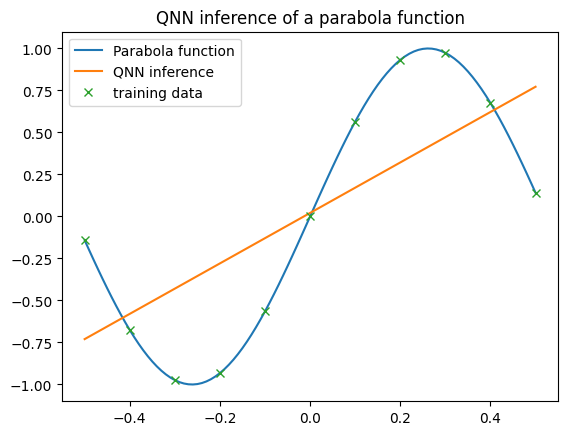

In [35]:
x = np.arange(np.min(x_train), np.max(x_train) + 0.01, 0.01)
y = qnn_simulator.predict(x)  # function for evaluating the prediction of the QNN
plt.plot(x, np.sin(6.0*x), label="Parabola function")
plt.plot(x, y, label="QNN inference")
plt.plot(x_train, y_train, "x", label="training data")
plt.legend()
plt.title("QNN inference of a parabola function")
plt.show()

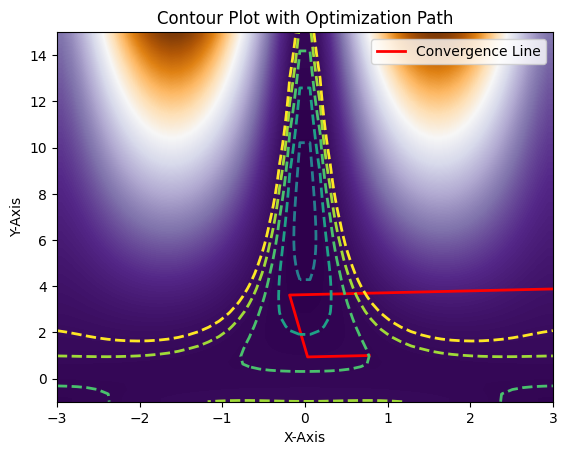

In [36]:
# Lese die Optimierungskoordinaten aus der Datei "params.log"
optimization_data = np.loadtxt("sglbo_noiseless_params2.log")
optimization_x = optimization_data[:, 0]
optimization_y = optimization_data[:, 1]

# plot the decision function for each datapoint on the grid
xx, yy = np.meshgrid(np.linspace(-3, 3, 50), np.linspace(-1, 15, 50))
Z = []
for i in range(len(xx)):
    for j in range(len(xx[i])):
        param = np.array([xx[i][j], yy[i][j]])
        Z.append(evaluate_loss(param, qnn_simulator, x_train, y_train))

Z = np.array(Z)
Z = Z.reshape(xx.shape)
#norm = mpl.colors.Normalize(vmin=-max(abs(np.min(Z)),abs(np.max(Z))), vmax=max(abs(np.min(Z)),abs(np.max(Z))))
im = plt.imshow(
    Z,
    interpolation="bilinear",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    aspect="auto",
    origin="lower",
    cmap=plt.cm.PuOr_r,
    #norm=norm
)

# Verbinde die Punkte im Scatter Plot mit einer Linie
plt.plot(optimization_x, optimization_y, c='red', linestyle='-', linewidth=2, label='Convergence Line')

# Plot backtransformed hyperplane
contours = plt.contour(xx, yy, Z, levels=[0,0.5,1,2,3,4,5,6,7], linewidths=2, linestyles="dashed")

# Plot training data
plt.axis([-3, 3, -1, 15])
plt.xlabel('X-Axis')
plt.ylabel('Y-Axis')
plt.title('Contour Plot with Optimization Path')
plt.legend()
plt.show()